<h1>Titanic</h1>

Top 8% on Kaggle with Stacking techniques.

Loading the libraries that are going to be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from vecstack import stacking
from xgboost import XGBClassifier

%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8) # plot size

I'll use 10-fold Cross-Validation to adjust my models.

In [2]:
kfolds = KFold(n_splits = 10, shuffle=True, random_state=2099)

Load the data.

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Merge the two datasets.

In [4]:
train['dataset'] = 'train'
test['dataset'] = 'test'
train = train.append(test)

Taking a look at the numerical variables in the dataset.

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Taking a look at all the variables in the dataset and their basic stats.

In [6]:
stats = train.describe().T
for i in range(len(train.columns)):
    stats.loc[train.columns[i], 'mode'], stats.loc[train.columns[i], 'mode_count'] = mode(train[train.columns[i]])
    stats.loc[train.columns[i], 'unique_values'] = train[train.columns[i]].value_counts().size
    stats.loc[train.columns[i], 'NaN'] = train[train.columns[i]].isnull().sum()
    if np.isnan(stats.loc[train.columns[i], 'count']): 
        stats.loc[train.columns[i], 'count'] = train.shape[0] - stats.loc[train.columns[i], 'NaN']
stats = stats[['count', 'NaN', 'unique_values', 'mode', 'mode_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
stats.index.name = 'variable'
stats.reset_index(inplace = True)
stats

,variable,count,NaN,unique_values,mode,mode_count,mean,std,min,25%,50%,75%,max
0,PassengerId,1309.0,0.0,1309.0,1,1.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
1,Survived,891.0,418.0,2.0,0,549.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000
2,Pclass,1309.0,0.0,3.0,3,709.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
3,Age,1046.0,263.0,98.0,24,47.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
4,SibSp,1309.0,0.0,7.0,0,891.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
5,Parch,1309.0,0.0,8.0,0,1002.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
6,Fare,1308.0,1.0,281.0,8.05,60.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292
7,Name,1309.0,0.0,1307.0,"Connolly, Miss. Kate",2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Sex,1309.0,0.0,2.0,male,843.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Ticket,1309.0,0.0,929.0,CA. 2343,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Name</h2>

It looks like the variable 'Name' has also titles in it. Let's check it. 

In [7]:
train['Name'].tail()

413              Spector, Mr. Woolf
414    Oliva y Ocana, Dona. Fermina
415    Saether, Mr. Simon Sivertsen
416             Ware, Mr. Frederick
417        Peter, Master. Michael J
Name: Name, dtype: object

Ok. So I'll create a new variable with each person's title.

In [8]:
train['Title'] = train['Name'].str.split('.', n = 2, expand = True)[[0]]
train['Title'] = train['Title'].str.split(',', n = 2, expand = True)[[1]]
train['Title'] = train['Title'].str.strip()

In [9]:
train.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Mme               1
Don               1
Sir               1
the Countess      1
Dona              1
Lady              1
Capt              1
Jonkheer          1
Name: Title, dtype: int64

I'll aggregate some titles.

In [10]:
train.loc[train[train['Title'].isin(['Mlle', 'Ms', 'Mme'])].index, 'Title'] = 'Miss'

In [11]:
train.loc[train[train['Title'].isin(['Don', 'Dona', 'Sir', 'the Countess', 'Lady', 'Jonkheer'])].index, 'Title'] = 'Nobility'

In [12]:
train.loc[train[train['Title'].isin(['Major', 'Col', 'Capt'])].index, 'Title'] = 'Others'

In [13]:
train.Title.value_counts()

Mr          752
Miss        266
Mrs         197
Master       61
Others        9
Nobility      8
Rev           8
Dr            8
Name: Title, dtype: int64

<h2>Embarked</h2>

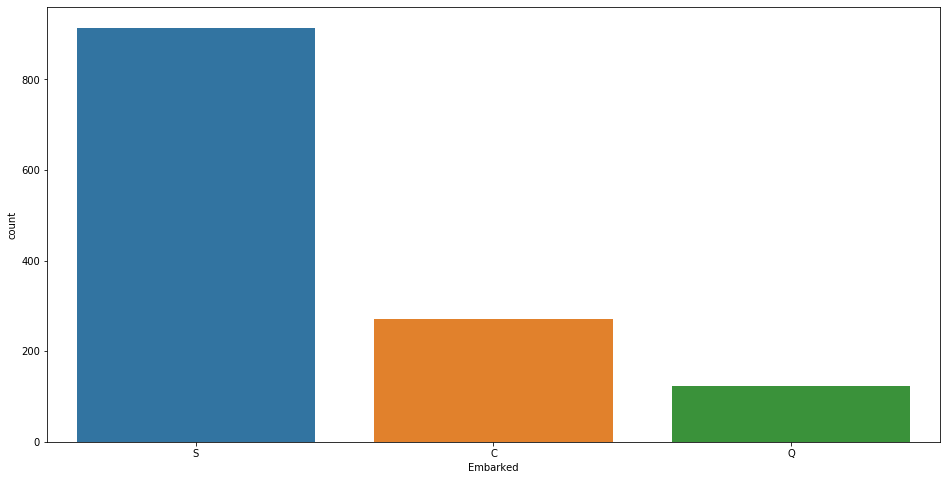

In [14]:
sns.countplot('Embarked', data = train)

Since there are only 2 NA's in $Embarked$ and the majority of people embarked in Southampton (S), I'll fill the NA values with the value S.

In [15]:
train['Embarked'].fillna('S', inplace = True)

<h2>FamilySize</h2>

I saw somewhere that people in bigger groups had more chances of survival, so I'm adding a variable to account for the group size.

In [16]:
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1

<h2>Female</h2>

I'm transforming the variable $gender$ into a dummy variable indicating if the person is $female$ or not.

In [17]:
train['Female'] = np.where(train['Sex'] == 'female', 1, 0)

<h2>1st, 2nd and 3rd Class</h2>

Dummy variables indicating whether the passengers were in 1st, 2nd or 3rd class.

In [18]:
train['1stClass'] = np.where(train['Pclass'] == 1, 1, 0)
train['2ndClass'] = np.where(train['Pclass'] == 2, 1, 0)
train['3rdClass'] = np.where(train['Pclass'] == 3, 1, 0)

In [19]:
train['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

<h2>Age</h2>

Treating the missing cases in this variable is a lit bit more complex.

I did some exploratory analysis and decided to fill in the missing values in $age$ according to the median ages of people separating them by groups of different $titles$ and different $classes$. The graphs below show how each group can be aggregated by $title$ and $class$.

In [20]:
train['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

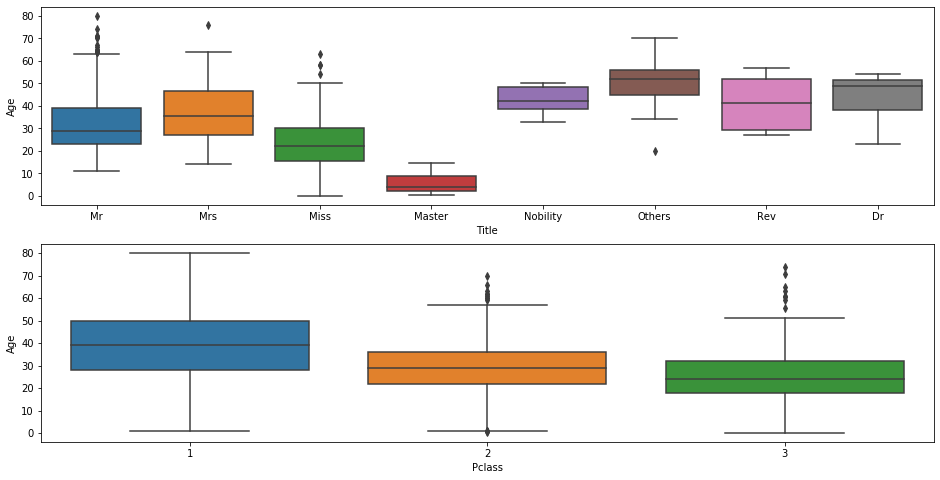

In [21]:
fig, ax = plt.subplots(2, 1)

sns.boxplot(x = 'Title', y = 'Age', data = train, ax = ax[0])
sns.boxplot(x = 'Pclass', y = 'Age', data = train, ax = ax[1])

In [22]:
pd.crosstab(train['Title'], train['Pclass'])

Pclass,1,2,3
Title,,,
Dr,6,2,0
Master,5,11,45
Miss,63,52,151
Mr,159,148,445
Mrs,77,55,65
Nobility,6,1,1
Others,7,0,2
Rev,0,8,0


In [23]:
pd.crosstab(train[pd.isna(train['Age'])]['Title'], train[pd.isna(train['Age'])]['Pclass'])

Pclass,1,2,3
Title,,,
Dr,1,0,0
Master,0,0,8
Miss,1,2,48
Mr,27,13,136
Mrs,10,1,16


In [24]:
# Dr. 1st Class
index = train[(train['Pclass'] == 1) & (train['Title'] == 'Dr') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 1) & (train['Title'] == 'Dr')]['Age'])
# Master 3rd Class
index = train[(train['Pclass'] == 3) & (train['Title'] == 'Master') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 3) & (train['Title'] == 'Master')]['Age'])
# Miss 1st Class
index = train[(train['Pclass'] == 1) & (train['Title'] == 'Miss') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 1) & (train['Title'] == 'Miss')]['Age'])
# Miss 2nd Class
index = train[(train['Pclass'] == 2) & (train['Title'] == 'Miss') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 2) & (train['Title'] == 'Miss')]['Age'])
# Miss 3rd Class
index = train[(train['Pclass'] == 3) & (train['Title'] == 'Miss') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 3) & (train['Title'] == 'Miss')]['Age'])
# Mr 1st Class
index = train[(train['Pclass'] == 1) & (train['Title'] == 'Mr') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 1) & (train['Title'] == 'Mr')]['Age'])
# Mr 2nd Class
index = train[(train['Pclass'] == 2) & (train['Title'] == 'Mr') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 2) & (train['Title'] == 'Mr')]['Age'])
# Mr 3rd Class
index = train[(train['Pclass'] == 3) & (train['Title'] == 'Mr') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 3) & (train['Title'] == 'Mr')]['Age'])
# Mrs 1st Class
index = train[(train['Pclass'] == 1) & (train['Title'] == 'Mrs') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 1) & (train['Title'] == 'Mrs')]['Age'])
# Mrs 2nd Class
index = train[(train['Pclass'] == 2) & (train['Title'] == 'Mrs') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 2) & (train['Title'] == 'Mrs')]['Age'])
# Mrs 3rd Class
index = train[(train['Pclass'] == 3) & (train['Title'] == 'Mrs') & pd.isna(train['Age'])].index
train.loc[index, 'Age'] = np.nanmedian(train[(train['Pclass'] == 3) & (train['Title'] == 'Mrs')]['Age'])

<h2>Fare</h2>

Since there's only one NA in $Fare$ I assumed that there's no much to gain to put much effort in figuring out the best value to fill in this missing value. For this reason I filled it with the median value of this variable.

In [25]:
train['Fare'].fillna(np.nanmedian(train['Fare']), inplace = True)

<h2>The Final Dataset</h2>

Here I present again the stats of my dataset after all the NA's have been replaced with more adequate values.

The only variables that still presents NA values are $Survived$ and $Cabin$. This is so because the final objective of this analysis is to predict the more adequate values to $Survived$ and I won't be using the variable $Cabin$ since I don't think it's worth it to fill in all the NA values in this variable given that they are more than 75% of it. Using this variable risks introducing some unwelcome bias in the analysis.

In [26]:
stats = train.describe().T
for i in range(len(train.columns)):
    stats.loc[train.columns[i], 'mode'], stats.loc[train.columns[i], 'mode_count'] = mode(train[train.columns[i]])
    stats.loc[train.columns[i], 'unique_values'] = train[train.columns[i]].value_counts().size
    stats.loc[train.columns[i], 'NaN'] = train[train.columns[i]].isnull().sum()
    if np.isnan(stats.loc[train.columns[i], 'count']): 
        stats.loc[train.columns[i], 'count'] = train.shape[0] - stats.loc[train.columns[i], 'NaN']
stats = stats[['count', 'NaN', 'unique_values', 'mode', 'mode_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
stats.index.name = 'variable'
stats.reset_index(inplace = True)
stats

,variable,count,NaN,unique_values,mode,mode_count,mean,std,min,25%,50%,75%,max
0,PassengerId,1309.0,0.0,1309.0,1,1.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
1,Survived,891.0,418.0,2.0,0,549.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000
2,Pclass,1309.0,0.0,3.0,3,709.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
3,Age,1309.0,0.0,92.0,26,215.0,28.770244,12.825334,0.42,21.0000,26.0000,36.000,80.0000
4,SibSp,1309.0,0.0,7.0,0,891.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
5,Parch,1309.0,0.0,8.0,0,1002.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
6,Fare,1309.0,0.0,281.0,8.05,60.0,33.281086,51.741500,0.00,7.8958,14.4542,31.275,512.3292
7,FamilySize,1309.0,0.0,9.0,1,790.0,1.883881,1.583639,1.00,1.0000,1.0000,2.000,11.0000
8,Female,1309.0,0.0,2.0,0,843.0,0.355997,0.478997,0.00,0.0000,0.0000,1.000,1.0000
9,1stClass,1309.0,0.0,2.0,0,986.0,0.246753,0.431287,0.00,0.0000,0.0000,0.000,1.0000


<h2>Dummy Variables</h2>

I create here some dummy variables that are going to be used in the regression models presented below.

In [27]:
train['Alone'] = np.where(train['FamilySize'] == 1, 1, 0)
train['Mr'] = np.where(train['Title'] == 'Mr', 1, 0)
train['Mrs'] = np.where(train['Title'] == 'Mrs', 1, 0)
train['Miss'] = np.where(train['Title'] == 'Miss', 1, 0)
train['Master'] = np.where(train['Title'] == 'Master', 1, 0)
train['female'] = np.where(train['Sex'] == 'female', 1, 0)
train['1stClass'] = np.where(train['Pclass'] == 1, 1, 0)
train['2ndClass'] = np.where(train['Pclass'] == 2, 1, 0)
train['3rdClass'] = np.where(train['Pclass'] == 3, 1, 0)
train['Embarked_S'] = np.where(train['Embarked'] == 'S', 1, 0)
train['Embarked_C'] = np.where(train['Embarked'] == 'C', 1, 0)
train['Embarked_Q'] = np.where(train['Embarked'] == 'Q', 1, 0)

<h2>X_train, y_train and X_test</h2>

Separate the dataset into X_train, y_train and X_test.

In [28]:
X_train = train[train['dataset'] == 'train'][['Age', 'SibSp', 'Parch', 'FamilySize', 'Alone', 'Fare', 'Embarked_S', 'Embarked_Q', 'Mr', 'Mrs', 'Miss', 'Master', 'female', '1stClass', '2ndClass']]
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = train[train['dataset'] == 'test'][['Age', 'SibSp', 'Parch', 'FamilySize', 'Alone', 'Fare', 'Embarked_S', 'Embarked_Q', 'Mr', 'Mrs', 'Miss', 'Master', 'female', '1stClass', '2ndClass']]
X_test = scaler.transform(X_test)
y_train = np.ravel(train[train['dataset'] == 'train'][['Survived']])

<h1>Regression Models</h1>

These are the Classification Models employed in this analysis:

- 2.1 Logistic Regression
- 2.2 Naïve Bayes
- 2.3 Stochastic Gradient Descent
- 2.4 K-Nearest Neighbours
- 2.5 Support Vector Classifier
- 2.6 Decision Tree
- 2.7 Random Forest
- 2.8 XGBoost Classifier
- 2.9 LightGBM Classifier

Below you can see the cross validation technique used to choose the more adequate parameters to fit the models to the data.

<h2>Logistic Regression</h2>

In [29]:
# define the grid search parameters
parameters = {
    'penalty': ['l2', 'elasticnet'],
    'C': [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1],
    'l1_ratio': [0.0, 0.05, 0.1],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1e7]
}

logistic_clf = GridSearchCV(LogisticRegression(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
logistic_clf.fit(X_train, y_train)
print(logistic_clf.best_params_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  56 tasks      | elapsed:    2.1s


{'C': 0.03125, 'l1_ratio': 0.05, 'max_iter': 10000000.0, 'penalty': 'elasticnet', 'solver': 'saga'}


[Parallel(n_jobs=3)]: Done 960 out of 960 | elapsed:    8.2s finished


In [30]:
logistic = LogisticRegression(penalty = 'elasticnet', C = 1/32, l1_ratio = 0.05, max_iter = 1e7, solver = 'saga')

<h2>Naive Bayes</h2>

In [31]:
# define the grid search parameters
parameters = {
    'alpha': [1e-10, 1e-5, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
}

naiveBayes_clf = GridSearchCV(BernoulliNB(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
naiveBayes_clf.fit(X_train, y_train)
print(naiveBayes_clf.best_params_)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 10 folds for each of 22 candidates, totalling 220 fits
{'alpha': 1e-10}


[Parallel(n_jobs=3)]: Done 191 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 220 out of 220 | elapsed:    0.5s finished


In [32]:
naiveBayes = BernoulliNB(alpha = 1e-10)

<h2>Stochastic Gradient Descent</h2>

In [33]:
# define the grid search parameters
parameters = {
    'loss': ['modified_huber', 'log'],
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1],
    'random_state': [2099],
    'early_stopping': [True]
}

sgd_clf = GridSearchCV(SGDClassifier(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
sgd_clf.fit(X_train, y_train)
print(sgd_clf.best_params_)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


{'alpha': 0.1, 'early_stopping': True, 'loss': 'modified_huber', 'random_state': 2099}


[Parallel(n_jobs=3)]: Done 140 out of 140 | elapsed:    0.7s finished


In [34]:
sgd = SGDClassifier(loss = 'modified_huber', alpha = 0.1, early_stopping = True, random_state = 2099)

<h2>K-Nearest Neighbours</h2>

In [35]:
# define the grid search parameters
parameters = {
    'n_neighbors': [1, 5, 10, 15, 17, 19, 21, 23],
}

knn_clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
knn_clf.fit(X_train, y_train)
print(knn_clf.best_params_)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'n_neighbors': 17}


[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed:    0.5s finished


In [36]:
knn = KNeighborsClassifier(n_neighbors = 17)

<h2>Support Vector Classifier</h2>

In [37]:
# define the grid search parameters
parameters = {
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'kernel': ['rbf'],
    'gamma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 1],
    'random_state': [2099]
}

svc_clf = GridSearchCV(SVC(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
svc_clf.fit(X_train, y_train)
print(svc_clf.best_params_)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=3)]: Done 110 tasks      | elapsed:    1.4s
[Parallel(n_jobs=3)]: Done 594 tasks      | elapsed:    8.3s


{'C': 5, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 2099}


[Parallel(n_jobs=3)]: Done 1100 out of 1100 | elapsed:   16.5s finished


In [38]:
svc = SVC(C = 5, gamma = 0.01, random_state = 2099)

<h2>Decision Tree</h2>

In [39]:
# define the grid search parameters
parameters = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ['sqrt'],
    'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'random_state': [2099]
}

tree_clf = GridSearchCV(DecisionTreeClassifier(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
tree_clf.fit(X_train, y_train)
print(tree_clf.best_params_)

Fitting 10 folds for each of 3150 candidates, totalling 31500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 346 tasks      | elapsed:    0.7s
[Parallel(n_jobs=3)]: Done 4218 tasks      | elapsed:    8.4s
[Parallel(n_jobs=3)]: Done 10714 tasks      | elapsed:   20.9s
[Parallel(n_jobs=3)]: Done 19770 tasks      | elapsed:   37.5s
[Parallel(n_jobs=3)]: Done 31419 tasks      | elapsed:   59.1s
[Parallel(n_jobs=3)]: Done 31500 out of 31500 | elapsed:   59.2s finished


{'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'random_state': 2099}


In [40]:
tree = DecisionTreeClassifier(max_depth = 4, min_samples_split = 2, min_samples_leaf = 7, max_features = 'sqrt', max_leaf_nodes = 10, random_state = 2099)

<h2>Random Forest</h2>

In [41]:
# define the grid search parameters
parameters = {
    'n_estimators': [100],
    'max_depth': [2, 4, 8, 16, 24, 32],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt'],
    'max_leaf_nodes': [18, 24, 32, 36],
    'max_samples': [0.7],
    'oob_score': [True],
    'random_state': [2099]
}

randomforest_clf = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
randomforest_clf.fit(X_train, y_train)
print(randomforest_clf.best_params_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done 306 tasks      | elapsed:   29.6s
[Parallel(n_jobs=3)]: Done 527 tasks      | elapsed:   53.2s
[Parallel(n_jobs=3)]: Done 810 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done 1175 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 1620 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 2147 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 2754 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 3443 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done 3600 out of 3600 | elapsed:  6.0min finished


{'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 18, 'max_samples': 0.7, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True, 'random_state': 2099}


In [42]:
randomforest = RandomForestClassifier(n_estimators = 1000, max_depth = 8, min_samples_split = 2, min_samples_leaf = 6, max_features = 'sqrt', max_leaf_nodes = 18, max_samples = 0.7, oob_score = True, random_state = 2099)

<h2>XGBoost Classifier</h2>

In [43]:
# define the grid search parameters
parameters = {
    'colsample_bytree': [.7, .825, .9, .95],
    'gamma': [0, .5, 1], 
    'learning_rate': [1e-3, 2e-3, 1e-2, .1], 
    'max_depth': [2, 4, 8, 16, 32], 
    'min_child_weight': [0, 1, 2, 4, 6], 
    'subsample': [.75, 1],
    'random_state': [2099]
}

xgboost_clf = GridSearchCV(XGBClassifier(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
xgboost_clf.fit(X_train, y_train)
print(xgboost_clf.best_params_)

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  43 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done 285 tasks      | elapsed:   17.5s
[Parallel(n_jobs=3)]: Done 691 tasks      | elapsed:   44.5s
[Parallel(n_jobs=3)]: Done 1257 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 1987 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 2877 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 3781 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 4458 tasks      | elapsed:  5.3min
[Parallel(n_jobs=3)]: Done 5417 tasks      | elapsed:  6.7min
[Parallel(n_jobs=3)]: Done 6591 tasks      | elapsed:  8.3min
[Parallel(n_jobs=3)]: Done 7861 tasks      | elapsed:  9.9min
[Parallel(n_jobs=3)]: Done 9240 tasks      | elapsed: 11.8min
[Parallel(n_jobs=3)]: Done 10565 tasks      | elapsed: 13.9min
[Parallel(n_jobs=3)]: Done 12492 tasks      | elapsed: 16.7min
[Parallel(n_jobs=3)]: Done 14620 tasks      | elapsed: 19.

{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 16, 'min_child_weight': 0, 'random_state': 2099, 'subsample': 1}


In [44]:
# define the grid search parameters
parameters = {
    'colsample_bytree': [.7, .75],
    'gamma': [.5, 1, 1.5, 2], 
    'learning_rate': [1e-2, .1], 
    'max_depth': [9, 10, 11, 12, 13, 14, 15],
    'min_child_weight': [0, 1], 
    'subsample': [1],
    'random_state': [2099]
}

xgboost_clf = GridSearchCV(XGBClassifier(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
xgboost_clf.fit(X_train, y_train)
print(xgboost_clf.best_params_)

Fitting 10 folds for each of 224 candidates, totalling 2240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   22.2s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:   50.7s
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 1452 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 1979 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 2240 out of 2240 | elapsed:  4.5min finished


{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 0, 'random_state': 2099, 'subsample': 1}


In [45]:
xgboost = XGBClassifier(colsample_bytree = 0.7, gamma = 1, learning_rate = 0.01, max_depth = 11, min_child_weight = 0, n_estimators = 1000, subsample = 1, random_state = 2099)

<h2>LightGBM Classifier</h2>

In [46]:
# define the grid search parameters
parameters = {
    'boosting_type': ['gbdt'],
    'num_leaves': [2, 4, 6, 8, 10, 12, 16, 20], 
    'learning_rate': [.001, .01, .1], 
    'max_depth': [2, 4, 8, 10, 12], 
    'min_child_weight': [0.01, 0.1, 1, 2], 
    'colsample_bytree': [1],
    'objective': ['binary'],
    'random_state': [2099]
}

lgbm_clf = GridSearchCV(LGBMClassifier(), parameters, scoring = 'f1',cv = kfolds, verbose = 2, n_jobs = 3)
lgbm_clf.fit(X_train, y_train)
print(lgbm_clf.best_params_)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  83 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done 567 tasks      | elapsed:    9.5s
[Parallel(n_jobs=3)]: Done 1379 tasks      | elapsed:   25.7s
[Parallel(n_jobs=3)]: Done 2511 tasks      | elapsed:   46.0s
[Parallel(n_jobs=3)]: Done 3971 tasks      | elapsed:  1.2min


{'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.01, 'num_leaves': 6, 'objective': 'binary', 'random_state': 2099}


[Parallel(n_jobs=3)]: Done 4800 out of 4800 | elapsed:  1.5min finished


In [47]:
lgbm = LGBMClassifier(colsample_bytree = 1, learning_rate = 0.1, max_depth = 4, min_child_weight = 0.01, num_leaves = 6, objective = 'binary', random_state = 2099)

<h2>Stacking</h2>

I stack all the predictors to make use of a meta classifier.

In [48]:
logistic = LogisticRegression(penalty = 'elasticnet', C = 1/32, l1_ratio = 0.05, max_iter = 1e7, solver = 'saga')
naiveBayes = BernoulliNB(alpha = 1e-10)
sgd = SGDClassifier(loss = 'modified_huber', alpha = 0.1, early_stopping = True, random_state = 2099)
knn = KNeighborsClassifier(n_neighbors = 17)
svc = SVC(C = 5, gamma = 0.01, random_state = 2099)
tree = DecisionTreeClassifier(max_depth = 4, min_samples_split = 2, min_samples_leaf = 7, max_features = 'sqrt', max_leaf_nodes = 10, random_state = 2099)
randomforest = RandomForestClassifier(n_estimators = 1000, max_depth = 8, min_samples_split = 2, min_samples_leaf = 6, max_features = 'sqrt', max_leaf_nodes = 18, max_samples = 0.7, oob_score = True, random_state = 2099)
xgboost = XGBClassifier(colsample_bytree = 0.7, gamma = 1, learning_rate = 0.01, max_depth = 11, min_child_weight = 0, n_estimators = 1000, subsample = 1, random_state = 2099)
lgbm = LGBMClassifier(colsample_bytree = 1, learning_rate = 0.1, max_depth = 4, min_child_weight = 0.01, num_leaves = 6, objective = 'binary', random_state = 2099)

In [49]:
models = [logistic, naiveBayes, sgd, knn, svc, tree, randomforest, xgboost, lgbm]

S_train, S_test = stacking(models, X_train, y_train, X_test, regression = False, mode = 'oof_pred_bag', 
                           needs_proba = False, save_dir = None, metric = f1_score, 
                           n_folds = 10, stratified = False, shuffle = True, random_state = 2099, verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred_bag]
n_models:     [9]

model  0:     [LogisticRegression]
    fold  0:  [0.75000000]
    fold  1:  [0.77611940]
    fold  2:  [0.71875000]
    fold  3:  [0.81159420]
    fold  4:  [0.73015873]
    fold  5:  [0.81159420]
    fold  6:  [0.80000000]
    fold  7:  [0.81355932]
    fold  8:  [0.71875000]
    fold  9:  [0.81632653]
    ----
    MEAN:     [0.77468524] + [0.03932188]
    FULL:     [0.77341390]

model  1:     [BernoulliNB]
    fold  0:  [0.77083333]
    fold  1:  [0.71232877]
    fold  2:  [0.69565217]
    fold  3:  [0.80555556]
    fold  4:  [0.65671642]
    fold  5:  [0.80000000]
    fold  6:  [0.77922078]
    fold  7:  [0.72727273]
    fold  8:  [0.65714286]
    fold  9:  [0.71428571]
    ----
    MEAN:     [0.73190083] + [0.05204577]
    FULL:     [0.73509015]

model  2:     [SGDClassifier]
    fold  0:  [0.74418605]
    fold  1:  [0.75757576]
    fold  2:  [0.71875000]
    fo

My meta classifier is a simple majority vote algorithm: if most of my predictors predict the person survived, the algorithm also predicts it. Otherwise it predicts the person didn't survive.

I chose to use a majority voting algorithm as a meta classifier because it's recommended to use a simple algorithm to make the final prediction after using stacking techniques.

In [50]:
model = VotingClassifier(estimators=[('logistic', logistic), ('naiveBayes', naiveBayes), ('sgd', sgd),
                                     ('knn', knn), ('svc', svc), ('tree', tree), ('randomforest', randomforest),
                                     ('xgboost', xgboost), ('lgbm', lgbm)], voting = 'hard')
model = model.fit(S_train, y_train)
y_pred = model.predict(S_test)

In [51]:
test['Survived'] = y_pred.astype(int)
submission = test[['PassengerId', 'Survived']]

In [52]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [53]:
submission.to_csv('TitanicPaulopcplNotebook.csv', index = False)